V tomto příkladu budeme pracovat s Bibliografií českého literárního exilu, která obsahuje záznamy o knihách a statích s literární tématikou, vydaných a publikovaných v českých exilových nakladatelstvích a časopisech. Nás budou zajímat pouze záznamy o statích, u kterých jsou uvedeni autor a časopis, ve kterém stať vyšla. Ty najdeme v polích 100 $a (respektive 100 $7) a 773 $t. Ukážeme si, jak z dat získat jméno časopisu, jak data o autorech a časopisech následně zpracovat, a nakonec, jak z nich vytvořit strukturu bipartitního grafu, kterou vykreslíme pomocí knihovny matplotlib.    

### Nacteni dat

Nejprve načteme naše uložená csv data. Jak převést marcovou databázi do csv tabulky a pak csv tabulku načíst jsme si ukázali v předchozím příkladu. Csv tabulku z markové databáze lze vygenerovat i pomocí skriptu save_csv.py.

In [1]:
import pandas as pd

# 'data/csv/out_B.csv'
# 'data/csv/out_ret.csv'
# 'data/csv/out_smz.csv'
# 'data/csv/out_int.csv'
# 'data/csv/out_cle.csv'

database_type = 'cle'

path = 'data/csv/out_{}.csv'.format(database_type)

# Cesta k nasim datum
csv_data = path

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')
# Odstraneni zbytecneho sloupce
df = df.drop(['Unnamed: 0'], axis = 1)

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])


Abychom nemuseli psát stejný kód několikrát, napíšeme ho jednou do funkce, kterou pak jednoduše zavoláme. V tomto případě si napíšeme funkci, která nám z několika listů (seznamů) vnořených do sebe vytvoří jeden. To se nám bude hodit, až budeme chtít spočítat četnost výskytů míst vydání. 

In [2]:
# Funkce na "zplosteni" listu -> ze sloupce DataFramu vytvori jeden list se vsemi elementy 
def flatten_list(strings):
    flattened_list = []
    if strings is not None: # Zkontrolujeme, jestli element neni None
        for item in strings:
            if isinstance(item, str):  # Pokud je element string, pridame ho do seznamu
                flattened_list.append(item)
            elif isinstance(item, list):  # Rekurzivne zavola sebe
                flattened_list.extend(flatten_list(item))
        return flattened_list

### Extrahování a čištění dat

K časopisu je zpravidla připsáno i místo vydání. Pro naše účely nám stačí ale jen název časopisu. Proto pomocí regulárního výrazu (regex) odstraníme místo vydání, které je napsané buď v kulatých, nebo hranatých závorkách. 

In [3]:
import re
import numpy as np

# regex patern, ktery najde substring pred zavorkou
# r"^(.*?)\s*(?=\()" <- kulate zavorky
pattern_magazine = r"^(.*?)\s*(?=\()"   #r"(.*?)\[" # <- hranate zavory  

# Odstranime misto vydani v zavore (pokud je pritomno)
df['magazine'] = df['magazine'].apply(lambda x: [re.search(pattern_magazine, y).group(1) if re.search(pattern_magazine, y) else y for y in x])

# Zbavime se prebytecnych mezer na zacatku a na konci stringu
df['magazine'] = df['magazine'].apply(lambda x: [y.rstrip() for y in x])

unique_magazine = np.unique(flatten_list(df.magazine))
print(unique_magazine)

['150 000 slov' 'Acta' 'Archa' 'Bohemia' 'Demokracia v exile'
 'Demokracie v exilu' 'Hlas exilu'
 'Information Service of Free Czechoslovakia'
 'Kalendář československého exilu'
 'Klub : informace Klubu čtenářů CCC Books' 'Listy' 'Magazín'
 'Modrá revue' 'Most a.t.d.' 'Naši v Holandsku' 'Nové obzory' 'Nový život'
 'Národní politika' 'Obrys' 'Okno dokořán' 'Paternoster' 'Perspektivy'
 'Premeny' 'Proměny' 'Právo lidu' 'Reportér' 'Rozmluvy' 'Sborník Bohemia'
 'Sklizeň' 'Sklizeň svobodné tvorby' 'Skutečnost' 'Spektrum' 'Spektrum :'
 'Studie' 'Svědectví' 'Telegram' 'Text' 'Zpravodaj'
 'Zpravodaj : sdružení čs. politických uprchlíků v Německu - Sdruženie čs. politických ubehlíkov v Německu'
 'Zvon' 'Západ' 'Zápisník' 'příl. Dokumentace Charty 77 1983'
 'příl. Knižní jídelníček' 'příl. časopisu Modrá revue'
 'Čechoslovák v zahraničí' 'Československý přehled' 'Česká příloha'
 'České slovo']


#### Zpracování



In [4]:
from collections import Counter 

author_code_column = 'author code'

# Vsichni autori ve sloupci
all_authors = flatten_list(df[author_code_column])

# Spocteme, v kolika zaznamech se autor objevil
counted_authors = Counter(all_authors)

# Pocet uzlu, ktere chceme vykreslit
n = 10

# Najdeme nejcastejsi autory, ktere pak zobrazime
most_common_authors = [item[0] for item in counted_authors.most_common(n)]

# Sloupec, ktery chceme zobrazit.
column = 'magazine'

# Zjistime indexy vsech radku, kde se objevuji autori, ktere chceme zobrazit 
ind = [True if any([True if author in most_common_authors else False for author in author_list]) else False for author_list in df[author_code_column]]

author_elements = df[ind][column]

unique_author_elements = np.unique(flatten_list(author_elements)) 

#### Mapping

Přiřadíme ke kódu autora jeho jméno

In [5]:
mapping = {}
most_common_authors_copy = most_common_authors.copy()
for idx,row in df.iterrows():
        if any(item in most_common_authors_copy for item in row[author_code_column]):
                for i, item in enumerate(row[author_code_column]):
                        if item in most_common_authors_copy:
                                mapping[item] = row['author'][i]
                                most_common_authors_copy.remove(item)
        if len(most_common_authors_copy)<1:
                break                                

### Vytvoření struktury grafu

In [6]:
%pip install networkx

import networkx as nx

# Vytvorime graf
G = nx.Graph()

# Elementy pridame grafu jako uzle
G.add_nodes_from(most_common_authors, bipartite=1)

# Vahy hran. Cim vice clanku v casopisu, tim vyssi vaha.
# Ve vykreslenem grafu pak bude vyssi vaha mit silnejsi caru. 
edge_weights = {}

# Iterujeme pres vsechny clanky
for _,row in df.iterrows():
    for element in row[column]:
        for author in row[author_code_column]:
            # Chceme vyselektovat jen desen nejcastejsich elemenu a casopisu
            if element in unique_author_elements and author in most_common_authors:
                if  (author, element) in edge_weights:
                    # Do dictionary hrany pridavame jako tuple 
                    edge_weights[(author, element)] += 1
                else:
                    edge_weights[(author, element)] = 1

# Vykreslime jen ty casopisy, ktere se objevuji vicekrat  
threshold = 10
left = []

for edge, weight in edge_weights.items():
    if weight>threshold:
        if ~G.has_node(edge[1]):
            left.append(edge[1])
            G.add_node(edge[1], bipartite=0) 
        G.add_edge(edge[0], edge[1], weight=weight)                

# Ke kodu autora pridame jeho skutecne jmeno
G = nx.relabel_nodes(G, mapping)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Vykreslení grafu

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


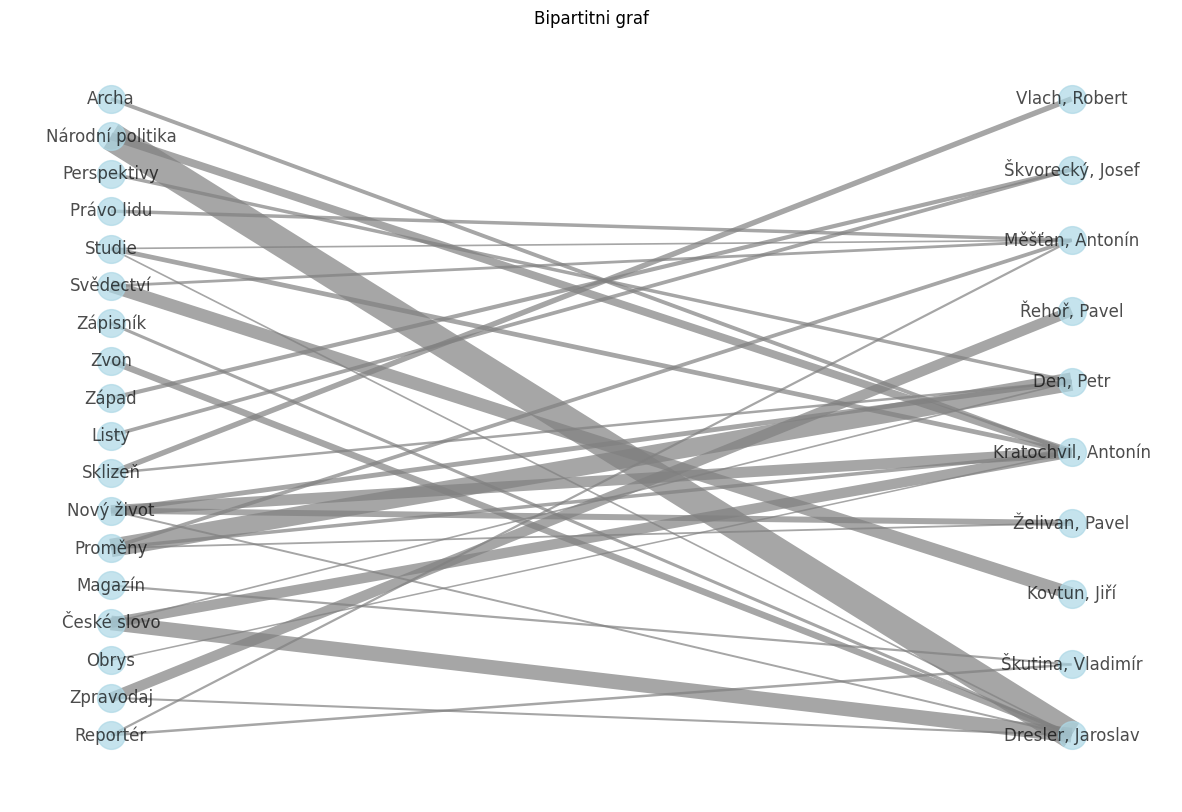

In [7]:
%pip install matplotlib

import matplotlib.pyplot as plt

pos = nx.bipartite_layout(G, nodes = left)
plt.figure(figsize=(15, 10))
edge_widths = [0.1 * G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', node_size=400,
                 width=edge_widths, edge_color='gray', alpha=0.7)
plt.title("Bipartitni graf")
plt.axis("off")
plt.show()